# Data Mining for Business Analytics
## From correlation to supervised segmentation and tree-structured models

Spring 2019 - Prof. George Valkanas

Material based on content courtesy of Prof. Foster Provost

***

## Recap and Motivation

The company we work for is running an ad-campaign for a new service that we want to offer. Our company has done similar campaigns in the past and has historical information about people we have previously reached out. For each such person, we know how they responded ("**Yes**", "**No**") plus certain characteristics that each individual has.

Reaching out to an individual incurs a certain cost. So, we would like to offer this new service to individuals who will respond positively.


**Questions**
* What type of (data mining) problem are we discussing?
* What is the target variable in our setting?

## Access to Historical Data
A sample of the people we have reached out to _in the past_ is shown in the image below, on the left hand side. Some of those people have responded positively ("Yes"), whereas others have responded negatively ("No").

Despite the easier visual presentation, the information on the left hand side image is not nicely _structured_. For data mining tasks, we (typically) want our data / information organized as shown on the right hand side image.

Of course, this is only an example, and we can have many more characteristics (read: attributes / features) for every individual. Such attributes may be:
* Marital status
* Number of kids
* Number of accepted invites in the past
* Number of rejected invites in the past
* Currently active user (with the service)
* Current plan cost (or average plan cost, if multiple ones)
* ...

<table style="border: 0px">
    <tr style="border: 0px">
        <td style="width: 35%; text-align: justify">
            <img width="100%" src="images/population.png"/> <br/>
            <span style="display: block; text-align: center">
                <b>Sample population of previous respondents</b>
            </span>
        </td>
        <td style="border: 0px; width: 5%"></td>
        <td style="display: block; text-align: justify">
            <img src="images/dataset.png" height=75% width=75% /> <br/>
            <span style="display: block; text-align: center">
                <b>A structured dataset for a data mining task</b>
            </span>
        </td>
    </tr>
</table>
<br/>

The business problem that we mentioned above maps to the following **data mining question:** _Given an individual's characteristics (age, salary, employment status, etc), how will they respond to our campaign?_

***

## Let's work with some data

For now, we will simply generate some data to play with. Though a real dataset would be more meaningful from an application standpoint, we would have to spend a lot of time to understand it, and even then, we would still be using only a portion of it to explain the core concepts below.

We will also start our scenario by working with two (2) dimensions.

### Packages and functions

We are going to need a lot of Python **packages**, so let's start by importing all of them.

In [1]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

We are also going to do a lot of repetitive stuff, so let's predefine some useful **FUNCTIONS**:

Remember the basic aspects of a function:

* Input -> Parameters
* Actions
* Output -> Return

(We might have no _return_ which is basically just an action usually known as procedure. Also, we will see in other classes that these functions can also be taken from a **SCRIPT !!!**)


In [2]:

# A function that picks a color for an instance, depending on its target variable
# We use 0 for "No" and "1" for yes.
# The function returns a list of items, one item for each instance (in the order given)
def Color_Data_Points(target):
    color = ["red" if t == 0 else "blue" for t in target]
    return color


# A function to plot the data in a scatter plot
# data: The data we want to visualize
# v1: The name used to access the X-axis variable information in the data parameter
# v2: The name used to access the Y-axis variable information in the data parameter
# tv: The name used to access the target variable information in the data parameter
def Plot_Data(data, v1, v2, tv):

    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = Color_Data_Points(data[tv])
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) , max(data[v1]) ])
    plt.ylim([min(data[v2]) , max(data[v2]) ])
    

### Data creation

We also need some data, so let's create a dataset consisting of **500** people (rows) with **3** different variables (columns): `["name", "age", "years_customer"]` 

The **target** of our prediction will be whether or not a person successfully responded to a previous ad that we ran. We will call it "response" ( **binary** -> 0/1 values ).

In [3]:
# Set the randomness
np.random.seed(36)

# Number of users, i.e. number of instances in our dataset
n_users = 500

# Features that we know about each user. The attributes below are for illustration purposes only!
variable_names = ["name", "age", "years_customer"]
variables_keep = ["years_customer", "age"]
target_name = "response"

# Generate data with the "datasets" function from SKLEARN (package)
# This function returns two variables: predictors and target

predictors, target = datasets.make_classification(n_features=3, n_redundant=0, 
                                                  n_informative=2, n_clusters_per_class=2,
                                                  n_samples=n_users)

# We will write this data in a dataframe (pandas package)

data = pd.DataFrame(predictors, columns=variable_names)

# We want to take each column of the dataframe to change the values 

data['age'] = data['age'] * 10 + 50
data['years_customer'] = (data['years_customer'] + 6)/2
data[target_name] = target

# Our variables (features) will be stored in one variable called X
X = data[variables_keep]

# Our target will be stored in one variable called Y
Y = data[target_name]


We can (and should) take a look at the first few rows/records of our data to see what we are dealing with.

In [4]:
# Show the first 5 values of our data
pd.concat([X, Y], axis=1).head(5)

,years_customer,age,response
0,2.231325,33.381085,0
1,2.887068,60.842598,0
2,1.561442,42.185568,0
3,2.582855,69.651130,0
4,2.443729,55.586017,0


## Let's visualize our data first
Before diving into the actual modeling, it is (generally) **great** practice to visualize the data that we have. Because we are dealing with _two-dimensional (2D) numerical data_ we can visualize our information in a _scatter plot_. Let's do that right now.

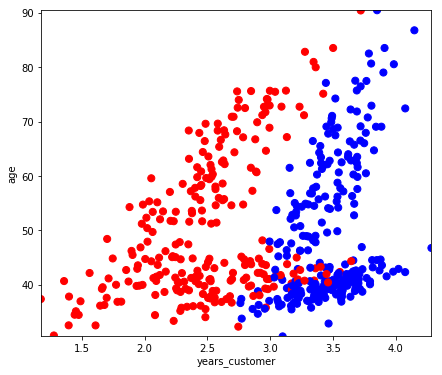

In [5]:
plt.figure(figsize=[7,6])
Plot_Data(data, "years_customer", "age", "response")

### Step-by-Step Approach

Before we dive into the technical solution of the problem, let's first state what we have and what we want to do. We have a 2D dataset, with two different classes. We are looking for a structured, repeatable and concise approach (i.e. **a model**) to distinguish between the two classes.

For a number of reasons, including simplicity, let's say that all we can do is draw **straight lines**. In fact, let's make things even simpler and say that we can only draw straight lines that are _parallel to the axes_ (either the X or the Y axis).

**Question 1:** Which axis (the "X" or the "Y") looks like a better candidate ?

**Question 2:** Where should we place the straight line in the above dataset, in order to _best_ separate the data points of the two classes ?

### One feature and splits
Let's take a look at one of our features -- **`"age"`**. Is this feature useful? 

- Let's look at a scatter plot the possible values of `"age"` and color code our target variable, `"response"`. Red dots mean unsuccessful people and blue dots mean successful people. 
- The horizontal value is the number of pets they have. The vertical position here doesn't mean anything (everyone has a one).

**Question:** By loooking at the scatter plot below, and only that information, does this look like a good variable to use to separate between the data?

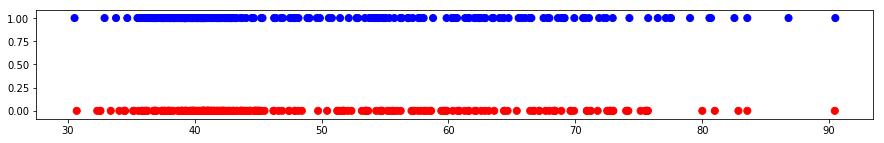

In [6]:
plt.rcParams['figure.figsize'] = [15.0, 2.0]

color = color = Color_Data_Points(data["response"])
plt.scatter(X['age'], Y, c=color, s=50)

#### Exercise
Produce the scatter plot for the variable **`"years_customer"`**

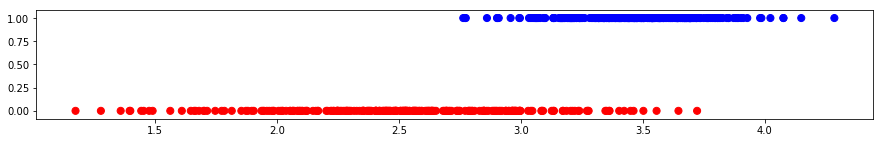

In [8]:
# add your code here
plt.rcParams['figure.figsize'] = [15.0, 2.0]

color = color = Color_Data_Points(data["response"])
plt.scatter(X['years_customer'], Y, c=color, s=50)

## Entropy ($H$) and Information Gain ($IG$)
***

Our earlier approach was guided visually. Though this may work well for us humans, it does not work for computers as nicely.

To achieve the same result mathematically, we will use **Entropy** ($H$). Entropy is a measure from thermodynamics that tells us how (dis)ordered a system is. We will use entropy to quantify the _homogeneity_ (or `purity`) of our data.

Mathematically, the entropy of a set with respect to a property of interest - in our case, the _target variable_, is given by the following quantity:

$ entropy = - p_1 \times \log(p_1) - p_2 \times \log(p_2) - \dots $

<img src="images/entropy.png" height=50% width=50%>


For our sample dataset, the entropy is as follows:

In [9]:
positive_class_count = Y[Y == 1].count()
positive_fraction = positive_class_count / Y.count()
negative_fraction = (Y.count() - positive_class_count) / Y.count()
entropy = -positive_fraction * math.log(positive_fraction, 2) - negative_fraction * math.log(negative_fraction, 2)

print("Total data points: ", Y.count())
print("Positive data points: ", positive_class_count)
print("Negative data points: ", (Y.count() - positive_class_count))
print("Entropy is", entropy)

Total data points:  500
Positive data points:  250
Negative data points:  250
Entropy is 1.0


**Information gain** ($IG$) builds on entropy and helps us determine which feature(s) is the most informative.

There are two steps in this process: 
1. We must pick a _feature_ to split
2. We must pick a _value_ of that feature to split on

Now, before splitting on a value, we have the entropy of the entire set, which we typically call the `parent` set when discussing information gain. After splitting, we get the `children` sets, and we can compute the entropy _for each_ of those sets. The information gain amount is given by the difference between the `parent entropy` and the sum of the `children entropies`.

Formally:

$IG(parent, children) = entropy(parent) - [p(c_1)\times entropy(c_1) + p(c_2)\times entropy(c_2) + \dots]$

The values $c_1$, $c_2$ and so on refer to the different children that we get by splitting on

Let's see an example with the split and information gain where we use the numeric `Balance` attribute (left hand side) and the categorical `Residence` attribute (right hand side).
_Note:_ these are new attributes, that we haven't mentioned above. Again, this is for illustration purposes.

<table style="border: 0px">
    <tr style="border: 0px">
        <td style="border: 0px; width: 45%; text-align: justify">
            <img src="images/dsfb_0304.png" height=80% width=80%> <br/>
            <b>Figure 3-4. Splitting the "response" sample into two segments, by splitting the Balance attribute (account balance) at 50K.</b>
        </td>
        <td style="border: 0px; width: 5%"></td>
        <td style="border: 0px; width: 45%; text-align: justify">
            <img src="images/dsfb_0305.png" height=100% width=100%>
            <b>Figure 3-5. A classification tree split on the three-values Residence attribute.</b>
        </td>
    </tr>
</table>

**Question:** Can you spot a difference between the two attributes above?

***

##### Functions to get the entropy and IG
Entropy and information gain are both relatively easy to calculate. As you can probably tell, we also use them quite repeatedy during the splitting process, so it makes sense to have them as methods.

In [10]:

def entropy(target):
    # Get the number of instances
    n = len(target)
    # Count how frequently each unique target value occurs using the numpy function 
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    
    # Otherwise, for each possible value, update entropy; use zero for 0 log 0
    for count in counts:
        if count == 0:
            entropy += 0
        else:
            entropy += math.log(count/n, 2) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

***
Let's go back to our toy example. Let's take a look again at our toy data, focusing on the `years_customer` feature alone.


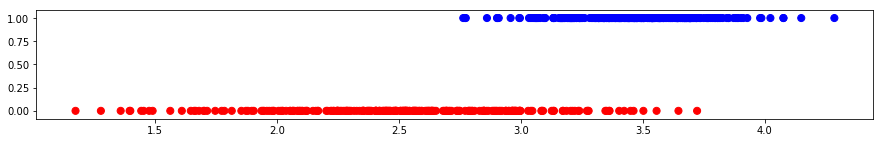

In [11]:
plt.rcParams['figure.figsize'] = [15.0, 2.0]

color = Color_Data_Points(data["response"])
plt.scatter(X['years_customer'], Y, c=color, s=50)

We have already said that `years_customer` looks like a good feature to split on. In fact, we said that `years_customer = 3` looks like a good threshold to use!

Let's see what we get with that `(feature, threshold)` combination in practice:
***

In [12]:
split_feature = "years_customer"  # The feature we are splitting
threshold = 3 # The threshold that we decided is a good one
print ("IG = %.4f with thresholding of %.2f." % (information_gain(X[split_feature], threshold, np.array(Y)), threshold))


IG = 0.5973 with thresholding of 3.00.


To be more precise, we can iterate through all values and find the best split.

In [13]:

def best_threshold():
    maximum_ig = 0
    maximum_threshold = 0

    split_on_feat = 'years_customer'

    for threshold in X[split_on_feat]:
        ig = information_gain(X[split_on_feat], threshold, np.array(Y))
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG = %.3f and it occured by splitting on %.4f." % (maximum_ig, maximum_threshold)

print ( best_threshold() )


The maximum IG = 0.603 and it occured by splitting on 3.0326.


### All features and splits with the sklearn package !

Let's see how we can do this with just sklearn! Now, we will be using all the variables in X, not only number of pets!

In [14]:
# A function that gives a visual representation of the decision tree

def Decision_Tree_Image(decision_tree, feature_names, class_names, name="tree",proportion=True):
    
    # Export our decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree, out_file='images/' + name + '.dot', 
                                    feature_names=feature_names, class_names=class_names,proportion=proportion)
        
    # Call graphviz to make an image file from our decision tree
    os.system("dot -Tpng images/" + name + ".dot -o images/" + name + ".png")
    # to get this part to actually work, you may need to open a terminal window in Jupyter and run the following command "sudo apt install graphviz"
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')

# A function that creates the surface of a decision tree

def Decision_Surface(data, target, model):
    # Get bounds
    x_min, x_max = data[data.columns[0]].min(), data[data.columns[0]].max()
    y_min, y_max = data[data.columns[1]].min(), data[data.columns[1]].max()

    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max,0.01), np.arange(y_min, y_max,0.01))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=[12,7])
    Z = model.predict(meshed_data).reshape(xx.shape)

    plt.title("Decision surface")    
    plt.ylabel("age")
    plt.xlabel("years_customer")

    color = Color_Data_Points(target)
    cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], colors=['#ff6666', '#66b2ff'] )
    plt.scatter(data[data.columns[0]], data[data.columns[1]], color=color, edgecolor='black' )



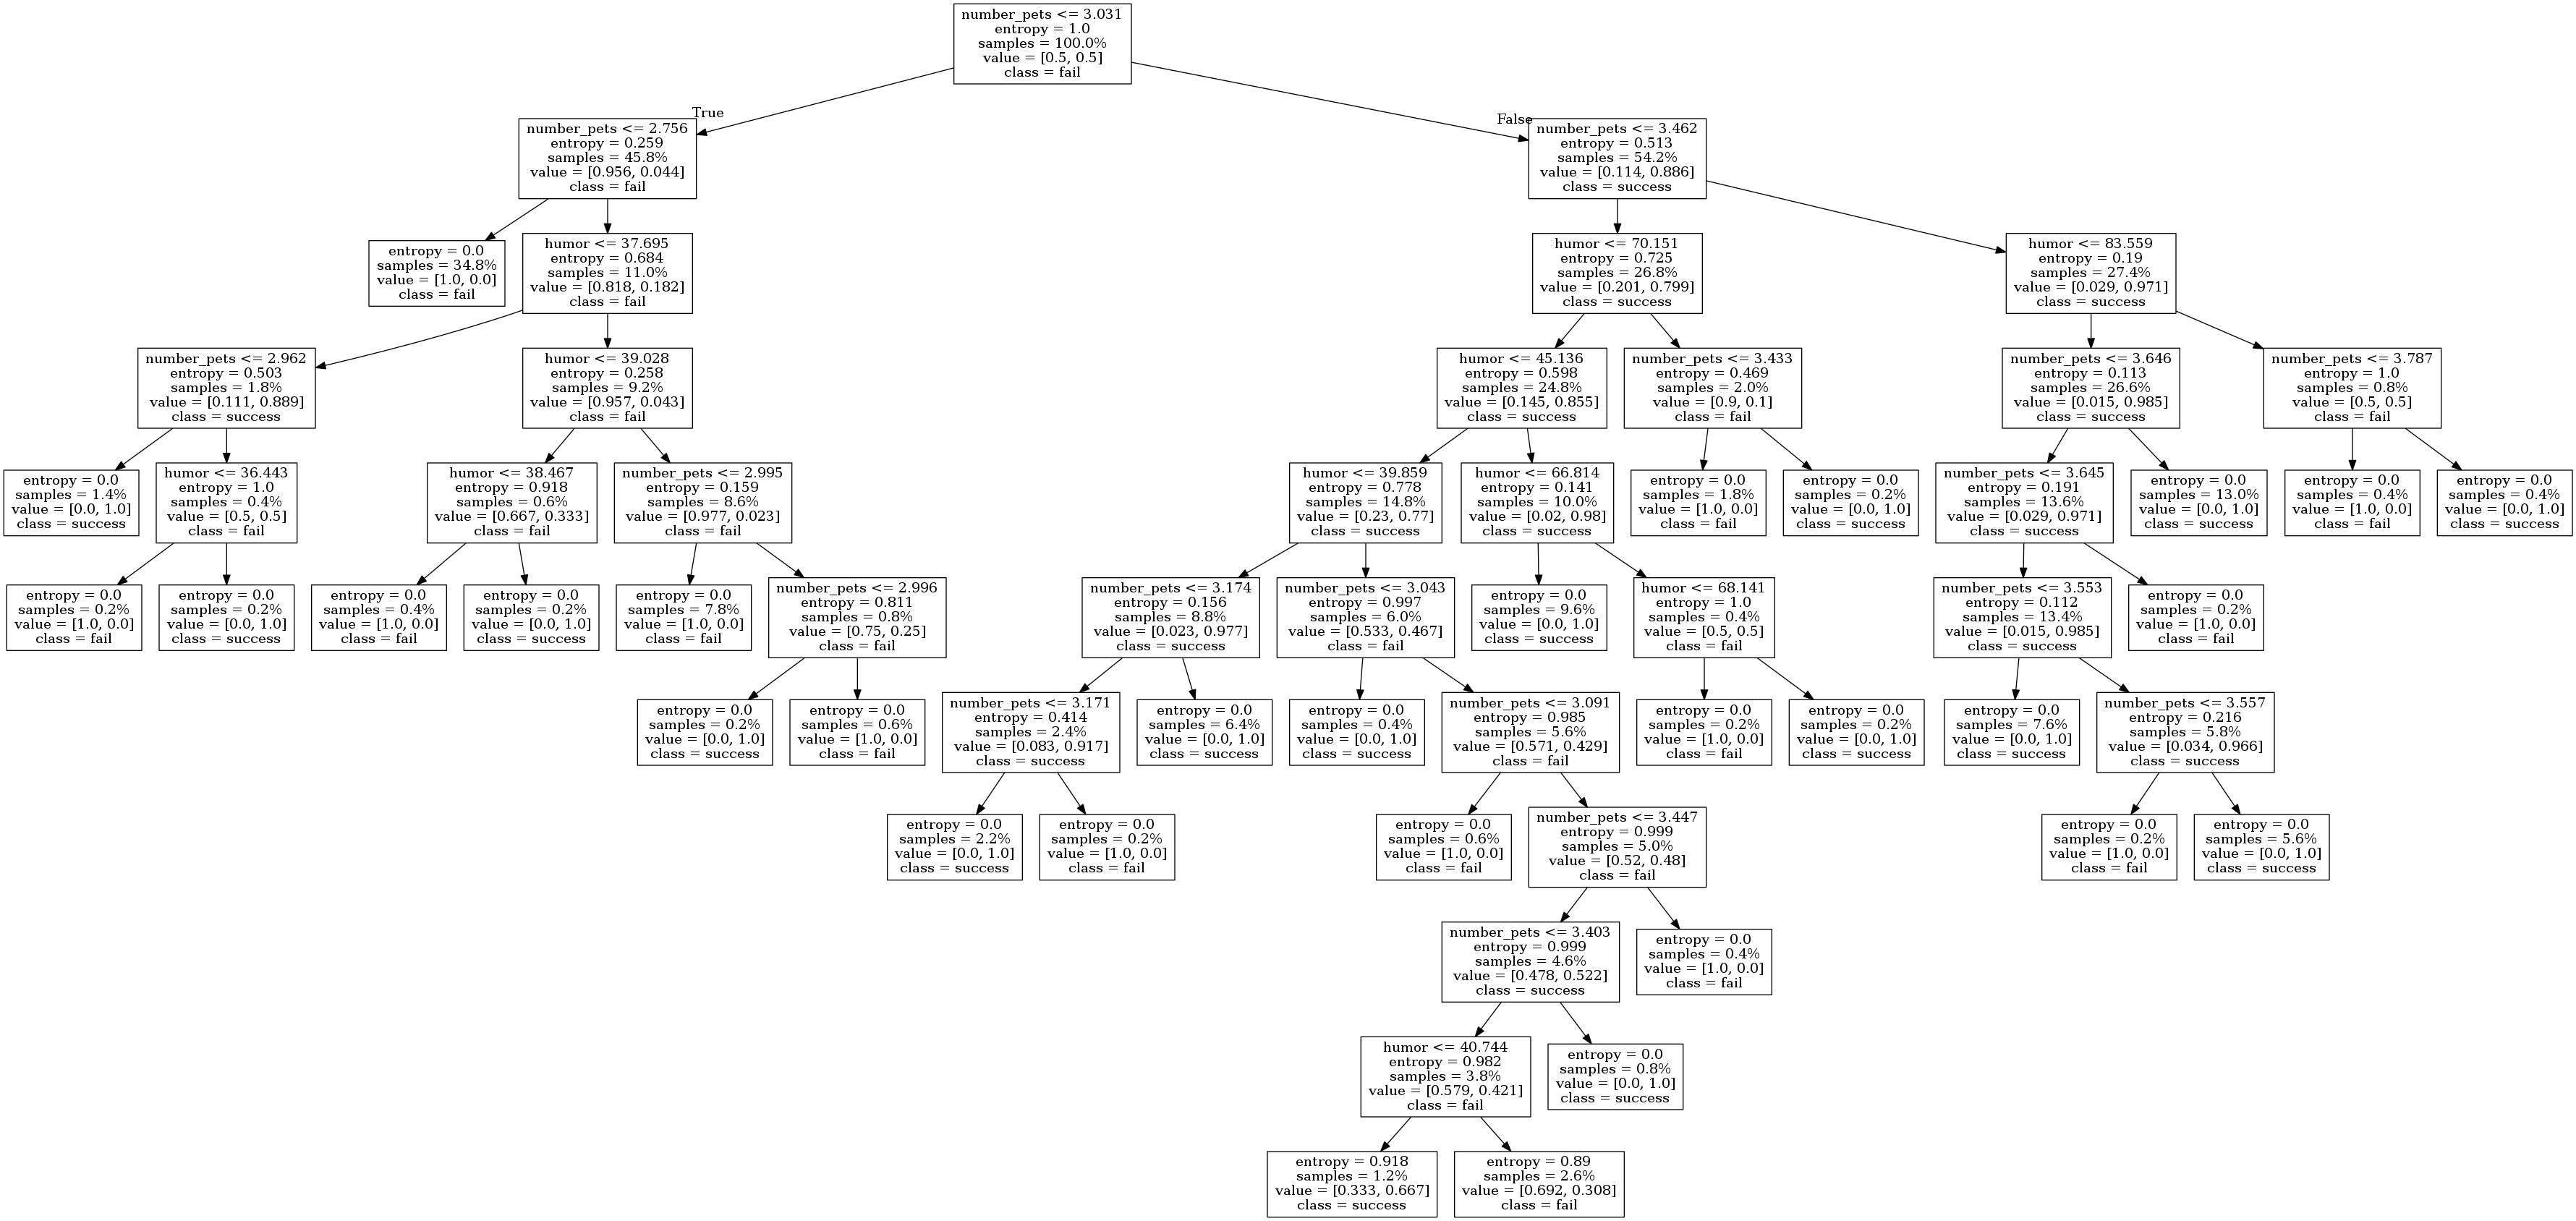

In [15]:
# Let's define the model (tree)
my_tree = DecisionTreeClassifier(max_depth=10,criterion="entropy")   # Look at those 2 arguments !!! 

# Let's tell the model what is the data
my_tree.fit(X, Y)

#Let's print an image with the results
Decision_Tree_Image(my_tree, X.columns, class_names =['fail','success'])

Let's look at the `"age"`and `"years_customer"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html)

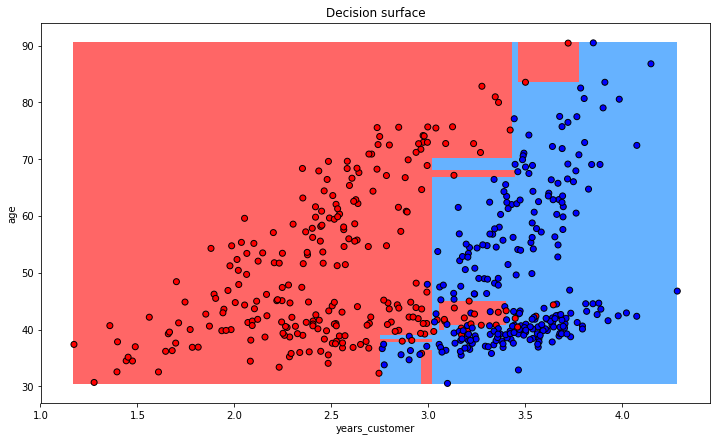

In [16]:
Decision_Surface(X,Y,my_tree)

In [17]:
print ( "Accuracy = %.3f" % (metrics.accuracy_score(my_tree.predict(X), Y)) )

Accuracy = 0.988
